## TVB-Framework command initialisation

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
data_path = work_path
tvb_conn_filepath = os.path.join(data_path, "Connectivity_res100_596_regions.h5")
outputs_path = os.path.join(work_path, "outputs/cereb")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-11-08 18:33:42,064 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-11-08 18:33:42,064 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-11-08 18:33:42,070 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-11-08 18:33:42,070 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-11-08 18:33:42,074 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-11-08 18:33:42,074 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-11-08 18:33:42,077 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-11-08 18:33:42,077 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-11-08 18:33:42,080 - INFO - tvb_multiscale.tv

# This loads the just-prepared data:

In [2]:
import h5py
from tvb.datatypes.connectivity import Connectivity

# Load connnectivity from file:
f = h5py.File(tvb_conn_filepath)
# We have to transpose the square connectivity matrices for TVB, because of the conversion w_ij => w_i<-j
result_connectivity = Connectivity(weights=np.array(f["weights"][()]).T, 
                                   tract_lengths=np.array(f["tract_lengths"][()]).T, 
                                   centres=np.array(f["centres"][()]), # hemispheres=np.array(f["hemispheres"][()]),
                                   region_labels=np.array(f["region_labels"][()]).astype("<U128"))
f.close()

# For the full connectome, self-connections are meaningless:
np.fill_diagonal(result_connectivity.weights, 0.0)
np.fill_diagonal(result_connectivity.tract_lengths, 0.0)

result_connectivity.configure()

print(result_connectivity.weights)
print(result_connectivity.region_labels)
print(result_connectivity.number_of_regions)
print(result_connectivity.weights.shape)
print(result_connectivity.tract_lengths.shape)


[[0.00000000e+00 3.63441680e-02 8.47970561e-02 ... 8.07329172e-07
  8.07329172e-07 1.02162597e-04]
 [3.32728901e-02 0.00000000e+00 5.49682272e-02 ... 2.73112949e-05
  2.85348052e-05 2.77993498e-05]
 [9.89313689e-02 6.43270451e-02 0.00000000e+00 ... 3.36029153e-05
  3.54584335e-05 9.15227954e-06]
 ...
 [1.36803986e-06 6.32084139e-05 2.99611362e-05 ... 0.00000000e+00
  1.00408312e-01 1.37087573e-02]
 [1.95515882e-07 5.04100941e-05 4.17897432e-05 ... 5.17439950e-02
  0.00000000e+00 2.65998675e-03]
 [2.71852623e-05 4.45484959e-04 2.03744779e-04 ... 3.86534058e-02
  3.67525396e-02 0.00000000e+00]]
['Right Frontal pole, cerebral cortex' 'Right Primary motor area'
 'Right Secondary motor area' 'Right Primary somatosensory area, nose'
 'Right Primary somatosensory area, barrel field'
 'Right Primary somatosensory area, lower limb'
 'Right Primary somatosensory area, mouth'
 'Right Primary somatosensory area, upper limb'
 'Right Primary somatosensory area, trunk'
 'Right Primary somatosensory a

## Summarize the major structures, except for the cerebellum

In [3]:
# Open the xls file and create a mapping between all regions and the major structures they belong each.

#pip install xlrd
try:
    import xlrd
except:
    import sys
    !{sys.executable} -m pip install xlrd
    import xlrd
    
sheet_data = []   
wb = xlrd.open_workbook(os.path.join(data_path, 'oh_table1.xls'))
p = wb.sheet_names()
#p[1]
#for y in p:
sh = wb.sheet_by_name(p[1])
print(sh)
for rownum in range(sh.nrows):
    sheet_data.append((sh.row_values(rownum)))

found_list = []
voxel_count = []
rows_to_be_saved = []
regions_missing = []
cc=0

for j in result_connectivity.region_labels: #go over the region labels
    j=j.split(" ",1)[1]
    #let us get rid of the left or right
    a=len(found_list)
    for i in sheet_data:
        if i[3] == j: #or i[2] == "string2" or i[2] == "string3" or i[2] == "string4" or i[2] == "string5":
            found_list.append(i[4])
            if i[5]:
                voxel_count.append(int(i[5]))
            else:
                voxel_count.append(-1)
        else:
            rows_to_be_saved.append(i)
    
    b=len(found_list)
    if a == b:
        regions_missing.append(j)
        found_list.append('X')
        voxel_count.append(-1)
        print(a,b)
    
    b=len(found_list)
    cc+=1
    if b != cc:
        print(b,cc)
print("Regions missing:\n%s" % str(regions_missing))
n_regs = len(found_list)
print("Number of regions: %d" % n_regs)
n_regs2 = n_regs/2
major_structures_labels = ["Right " + msl if iL <n_regs2 else "Left " + msl 
                           for iL, msl in enumerate(found_list)]
voxel_count = np.array(voxel_count).astype('i')
major_structures = np.unique(major_structures_labels)
print(major_structures)


Sheet  1:<Voxel Count_295 Structures>
Regions missing:
[]
Number of regions: 596
['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Medulla SPV' 'Left Midbrain'
 'Left Olfactory Areas' 'Left Pallidum' 'Left Pons Behavioral'
 'Left Pons Motor' 'Left Pons Sensory' 'Left Striatum' 'Left Thalamus'
 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla'
 'Right Medulla SPV' 'Right Midbrain' 'Right Olfactory Areas'
 'Right Pallidum' 'Right Pons Behavioral' 'Right Pons Motor'
 'Right Pons Sensory' 'Right Striatum' 'Right Thalamus']


In [4]:
print(np.array(list(zip(major_structures_labels, voxel_count))))

[['Right Isocortex' '514']
 ['Right Isocortex' '11760']
 ['Right Isocortex' '10098']
 ...
 ['Left Cerebellar Nuclei' '529']
 ['Left Cerebellar Nuclei' '250']
 ['Left Cerebellar Nuclei' '-1']]


In [5]:
from copy import deepcopy


def voxel_count_sum(arr, axis=0, **kwargs):
    voxel_count_sum = np.sum(arr[arr>0], axis=axis)
    print("Voxel count sum: %s" % str(voxel_count_sum))
    return voxel_count_sum

    
def repeat(arr, sub, axis=0, **kwargs):
    """This function will tile a subarray
       to create an array of shape similar to the input array's arr, 
       except for the axis given in the input, where size will be 1.
       It is used to substitute many labels by a single one."""
    shape = list(arr.shape)
    shape[axis] = 1
    return np.tile(sub, tuple(shape))
    

def delete(arr, axis=0, **kwargs):
    """This function returns an empty array 
       of shape similar to the input array's arr, 
       except for the axis given in the input, where size will be 0.
       It is used to delete a subarray."""
    shape = list(arr.shape)
    shape[axis] = 0
    return np.empty(tuple(shape))


def merge_axis(inds, arr, axis=0, fun=np.nansum):
    """This function will merge a subarray of the input array arr,
       as defined by the input indices inds, along the input axis,
       applying the function fun, in order to summarize the values."""
    new_arr = np.delete(arr, inds, axis)
    array_to_be_merged = np.take(arr, inds, axis)
    merged_arr = fun(array_to_be_merged, axis, keepdims=True)
    return np.insert(new_arr, [np.minimum(inds[0], new_arr.shape[axis])], merged_arr, axis=axis)
    # return np.concatenate((new_arr, merged_arr), axis=axis)
    
    
def merge_nD(inds, arr, fun=np.nansum):
    """This function will merge a subarray of the input array arr,
       as defined by the input indices inds, 
       along all the axes of arr (assuming same dimensionality along all axes),
       applying the function fun, in order to summarize the values."""
    new_arr = arr.copy()
    for ax in range(arr.ndim):
        new_arr = merge_axis(inds, new_arr, axis=ax, fun=fun)
    return new_arr


def merge_conn(conn, regions, new_label, weight_fun=np.nansum, configure=False):
    """This function will merge an input TVB connectivity conn, 
       for the input regions (indices or labels), 
       substituting them with a summarized region of label new_label, 
       applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    if np.issubdtype(regions.dtype, np.integer):
        inds = regions
    else:
        inds = []
        for iR, region in conn.region_labels:
            if region in regions:
                inds.append(iR)
    new_conn = deepcopy(conn)
    repeat_fun = lambda arr, axis=0, **kwargs: repeat(arr, new_label, axis, **kwargs)
    new_conn.region_labels = merge_axis(inds, conn.region_labels, axis=0, fun=repeat_fun)
    new_conn.centres = merge_axis(inds, conn.centres, axis=0, fun=np.nanmean)
    new_conn.weights = merge_nD(inds, conn.weights, fun=weight_fun)
    new_conn.tract_lengths = merge_nD(inds, conn.tract_lengths, fun=np.nanmean)
    if configure:
        new_conn.configure()
    return new_conn

    
def merge_major_structure(conn, major_struct_to_merge, major_structs_labels, voxel_count,
                          exclude_regions=[], weight_fun=np.nansum, configure=False):
    """This function will merge an input TVB connectivity conn, 
       for the input major structure label major_struct_to_merge,
       assuming an input vector major_structs_labels, mapping all regions to a major structure,
       substituting merged regions with a summarized region of the major structure label, 
       and applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    regions_inds = np.where([major_structs_label == major_struct_to_merge and 
                             region not in exclude_regions 
                             for region, major_structs_label in zip(conn.region_labels, major_structs_labels)])[0]
    print("...regions' indices of %s:\n%s" % (major_struct_to_merge, str(regions_inds)))
    repeat_fun = lambda arr, axis=0, **kwargs: repeat(arr, major_struct_to_merge, axis, **kwargs)
    return merge_conn(conn, regions_inds, major_struct_to_merge, weight_fun=weight_fun, configure=configure), \
           merge_axis(regions_inds, major_structs_labels, axis=0, fun=repeat_fun), \
           merge_axis(regions_inds, voxel_count, axis=0, fun=voxel_count_sum) 
    
    
def merge_major_structures(conn, major_structs_to_merge, major_structs_labels, voxel_count, 
                           exclude_regions={}, weight_fun=np.nansum):
    """This function will merge an input TVB connectivity conn, 
       for the input major structures labels major_structs_to_merge,
       assuming an input vector major_structs_labels, mapping all regions to a major structure,
       substituting merged regions with a summarized region of the respective major structure label, 
       and applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    new_conn = deepcopy(conn)
    new_major_structs_labels = major_structs_labels.copy()
    new_voxel_count = voxel_count.copy()
    for major_struct_to_merge in major_structs_to_merge:
        print("Merging %s ..." % major_struct_to_merge)
        new_conn, new_major_structs_labels, new_voxel_count = \
            merge_major_structure(new_conn, major_struct_to_merge, 
                                  new_major_structs_labels, new_voxel_count, 
                                  exclude_regions=exclude_regions.get(major_struct_to_merge, []), 
                                  weight_fun=weight_fun)
        
    new_conn.configure()
    return new_conn, new_major_structs_labels, new_voxel_count



In [6]:
def unilateral_to_bilateral_exclude_regions(major_structure, hemi, exclude_regions):
    new_exclude_regions = []
    if len(exclude_regions):
        if hemi == "Left":
            hemistr = "Left "
            hemidel = "Right "
        else:
            hemistr = "Right "
            hemidel = "Left "
        for reg in exclude_regions:
            if hemistr in reg:
                new_exclude_regions.append(reg)
            elif hemidel in reg:
                pass
            else:
                new_exclude_regions.append(hemistr + reg)
    return new_exclude_regions


    
def unilateral_to_bilateral(major_structures_to_merge, exclude_regions):
    # For bilateral merge: 
    new_major_structures_to_merge = []
    new_exclude_regions = {}
    for mstm in major_structures_to_merge:
        if "Left " not in mstm and "Right " not in mstm:
            left = "Left " + mstm
            new_major_structures_to_merge.append("Left " + mstm)
            new_major_structures_to_merge.append("Right " + mstm)
        else:
            new_major_structures_to_merge.append(mstm)
    new_major_structures_to_merge = np.unique(new_major_structures_to_merge)
    for hemimstm in new_major_structures_to_merge:
        if "Left " in hemimstm:
            hemi = "Left"
            mstm = hemimstm.split("Left ")[-1]
        else:
            hemi = "Right"
            mstm = hemimstm.split("Right ")[-1]
        new_exclude_regions[hemimstm] = \
            exclude_regions.get(hemimstm, 
                                unilateral_to_bilateral_exclude_regions(mstm, hemi, exclude_regions.get(mstm, [])))
    return new_major_structures_to_merge, new_exclude_regions

    
# Summarize all subcortical major structures except for the Cerebellar Cortices and Nuclei:
major_structures_to_merge = ['Cortical Subplate', 'Hippocampal Formation',  'Hypothalamus', 
                             'Medulla','Medulla SPV', 
                             'Midbrain', 'Olfactory Areas', 'Pallidum', 
                             'Pons Motor', 'Pons Sensory', 'Pons Behavioral', 
                             'Striatum', 'Thalamus']
exclude_regions={'Medulla': ["Inferior olivary complex", "Facial motor nucleus"], 
                 'Midbrain': ["Superior colliculus, motor related"]}

# For bilateral merging:
major_structures_to_merge, exclude_regions = unilateral_to_bilateral(major_structures_to_merge, exclude_regions)


In [7]:
print(major_structures_to_merge)
print(exclude_regions)

['Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Medulla' 'Left Medulla SPV' 'Left Midbrain' 'Left Olfactory Areas'
 'Left Pallidum' 'Left Pons Behavioral' 'Left Pons Motor'
 'Left Pons Sensory' 'Left Striatum' 'Left Thalamus'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Medulla' 'Right Medulla SPV' 'Right Midbrain'
 'Right Olfactory Areas' 'Right Pallidum' 'Right Pons Behavioral'
 'Right Pons Motor' 'Right Pons Sensory' 'Right Striatum' 'Right Thalamus']
{'Left Cortical Subplate': [], 'Left Hippocampal Formation': [], 'Left Hypothalamus': [], 'Left Medulla': ['Left Inferior olivary complex', 'Left Facial motor nucleus'], 'Left Medulla SPV': [], 'Left Midbrain': ['Left Superior colliculus, motor related'], 'Left Olfactory Areas': [], 'Left Pallidum': [], 'Left Pons Behavioral': [], 'Left Pons Motor': [], 'Left Pons Sensory': [], 'Left Striatum': [], 'Left Thalamus': [], 'Right Cortical Subplate': [], 'Right Hippo

In [8]:
new_conn, new_major_structs_labels, new_voxel_count = \
    merge_major_structures(result_connectivity, 
                           major_structures_to_merge,
                           major_structures_labels, voxel_count,
                           exclude_regions=exclude_regions, weight_fun=np.nansum)
sum_conn_new = new_conn.weights
print(np.array(list(zip(new_conn.region_labels, new_major_structs_labels, new_voxel_count))))

Merging Left Cortical Subplate ...
...regions' indices of Left Cortical Subplate:
[365 366 367 368 369 370 371]
Voxel count sum: 6669
Merging Left Hippocampal Formation ...
...regions' indices of Left Hippocampal Formation:
[352 353 354 355 356 357 358 359 360 361 362 363 364]
Voxel count sum: 34819
Merging Left Hypothalamus ...
...regions' indices of Left Hypothalamus:
[419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436
 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454
 455 456 457 458 459]
Voxel count sum: 13871
Merging Left Medulla ...
...regions' indices of Left Medulla:
[481 482 483 484 485 486 490 491 493 494 495 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519]
Voxel count sum: 17303
Merging Left Medulla SPV ...
...regions' indices of Left Medulla SPV:
[482 483 484]
Voxel count sum: 3107
Merging Left Midbrain ...
...regions' indices of Left Midbrain:
[420 421 422 423 424 425 426 427 428 429 4

In [9]:
# Testing that everything went well:
print("Testing merging, voxel counts, sum of (self/from/to) weights, and self-tract lengths:")
for iR, (reg, msl, vc) in enumerate(zip(new_conn.region_labels, new_major_structs_labels, new_voxel_count)):
    print("%s - %s:" % (reg, msl))
    if reg in result_connectivity.region_labels:
        iR2 = np.where([reg == reg2 for reg2 in result_connectivity.region_labels])[0]
        print("...%d = %d voxels" % (vc, voxel_count[iR2]))
        assert voxel_count[iR2] - vc == 0
        print("...centres: %s = %s" % (new_conn.centres[iR], result_connectivity.centres[iR2]))
        assert np.allclose(new_conn.centres[iR], result_connectivity.centres[iR2])
        ws = np.nansum(new_conn.weights[iR])
        ws2 = np.nansum(result_connectivity.weights[iR2])
        print("...weights to: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws = np.nansum(new_conn.weights[:, iR])
        ws2 = np.nansum(result_connectivity.weights[:, iR2])
        print("...weights from: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        print("...self tract_lengths: %g = %g" % (new_conn.tract_lengths[iR, iR], result_connectivity.tract_lengths[iR, iR]))
        assert np.abs(new_conn.tract_lengths[iR, iR] - result_connectivity.tract_lengths[iR, iR]) < 1e-6
    else:
        excl_regs = exclude_regions.get(reg, [])
        iR2s = np.where([msl == msl2 and reg2 not in excl_regs
                         for reg2, msl2 in zip(result_connectivity.region_labels, major_structures_labels)])[0]
        old_vc = voxel_count[iR2s]
        old_vc = old_vc[old_vc >= 0]
        old_vc_sum = old_vc.sum()
        print("...%d voxels" % old_vc_sum)
        assert old_vc_sum - vc == 0
        oldcntrs = np.nanmean(result_connectivity.centres[iR2s], axis=0)
        print("...centres: %s = %s" % (new_conn.centres[iR], oldcntrs))
        assert np.allclose(new_conn.centres[iR], oldcntrs)
        ws = np.nansum(new_conn.weights[iR])
        ws2 = np.nansum(result_connectivity.weights[iR2s])
        print("...weights to: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws = np.nansum(new_conn.weights[:, iR])
        ws2 = np.nansum(result_connectivity.weights[:, iR2s])
        print("...weights from: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws2 = np.nansum(result_connectivity.weights[iR2s][:, iR2s])
        print("...self weights: %g = %g" % (new_conn.weights[iR, iR], ws2))
        assert np.abs(new_conn.weights[iR, iR] - ws2) < 1e-6
        tl2 = np.nanmean(result_connectivity.tract_lengths[iR2s][:, iR2s])
        print("...self tract_lengths: %g = %g" % (new_conn.tract_lengths[iR, iR], tl2))
        assert np.abs(new_conn.tract_lengths[iR, iR] - tl2) < 1e-6
        

Testing merging, voxel counts, sum of (self/from/to) weights, and self-tract lengths:
Right Frontal pole, cerebral cortex - Right Isocortex:
...514 = 514 voxels
...centres: [45.5942029  22.72256729 51.2484472 ] = [[45.5942029  22.72256729 51.2484472 ]]
...weights to: 3.14868 = 3.14868
...weights from: 6.36079 = 6.36079
...self tract_lengths: 0 = 0
Right Primary motor area - Right Isocortex:
...11760 = 11760 voxels
...centres: [35.30080448 42.96502274 55.40433718] = [[35.30080448 42.96502274 55.40433718]]
...weights to: 1.87382 = 1.87382
...weights from: 6.37274 = 6.37274
...self tract_lengths: 0 = 0
Right Secondary motor area - Right Isocortex:
...10098 = 10098 voxels
...centres: [43.65873016 36.05326618 57.91804029] = [[43.65873016 36.05326618 57.91804029]]
...weights to: 2.33534 = 2.33534
...weights from: 6.99391 = 6.99391
...self tract_lengths: 0 = 0
Right Primary somatosensory area, nose - Right Isocortex:
...1358 = 1358 voxels
...centres: [21.02302632 56.74407895 54.42039474] = [[

...weights to: 109.003 = 109.003
...weights from: 98.3856 = 98.3856
...self weights: 10.0959 = 10.0959
...self tract_lengths: 21.3969 = 21.3969
Right Pallidum - Right Pallidum:
...9308 voxels
...centres: [45.81119109 54.53142794 25.16705593] = [45.81119109 54.53142794 25.16705593]
...weights to: 89.3808 = 89.3808
...weights from: 79.9628 = 79.9628
...self weights: 4.38613 = 4.38613
...self tract_lengths: 15.7417 = 15.7417
Right Thalamus - Right Thalamus:
...15670 voxels
...centres: [46.08270829 70.79795668 37.64692313] = [46.08270829 70.79795668 37.64692313]
...weights to: 444.525 = 444.525
...weights from: 295.554 = 295.554
...self weights: 72.7052 = 72.7052
...self tract_lengths: 15.6218 = 15.6218
Right Hypothalamus - Right Hypothalamus:
...13871 voxels
...centres: [50.08778601 63.01577052 16.74786055] = [50.08778601 63.01577052 16.74786055]
...weights to: 630.732 = 630.732
...weights from: 642.136 = 642.136
...self weights: 275.806 = 275.806
...self tract_lengths: 18.1211 = 18.1211


...weights from: 4.55941 = 4.55941
...self tract_lengths: 0 = 0
Left Ventral auditory area - Left Isocortex:
...2554 = 2554 voxels
...centres: [103.49225664  78.00110619  45.04535398] = [[103.49225664  78.00110619  45.04535398]]
...weights to: 3.64962 = 3.64962
...weights from: 7.59361 = 7.59361
...self tract_lengths: 0 = 0
Left Anterolateral visual area - Left Isocortex:
...1981 = 1981 voxels
...centres: [94.07672634 82.52173913 62.23529412] = [[94.07672634 82.52173913 62.23529412]]
...weights to: 3.36884 = 3.36884
...weights from: 6.11907 = 6.11907
...self tract_lengths: 0 = 0
Left Anteromedial visual area - Left Isocortex:
...1795 = 1795 voxels
...centres: [73.51295337 76.65025907 71.68911917] = [[73.51295337 76.65025907 71.68911917]]
...weights to: 3.6538 = 3.6538
...weights from: 7.05138 = 7.05138
...self tract_lengths: 0 = 0
Left Lateral visual area - Left Isocortex:
...880 = 880 voxels
...centres: [92.92718447 91.04530744 60.5566343 ] = [[92.92718447 91.04530744 60.5566343 ]]
..

Left Pons Behavioral - Left Pons Behavioral:
...3890 voxels
...centres: [ 62.84470772 102.57716104  31.39277175] = [ 62.84470772 102.57716104  31.39277175]
...weights to: 126.613 = 126.613
...weights from: 92.8137 = 92.8137
...self weights: 11.3319 = 11.3319
...self tract_lengths: 8.65806 = 8.65806
Left Medulla - Left Medulla:
...17303 voxels
...centres: [ 70.42437911 110.39039194  20.71936149] = [ 70.42437911 110.39039194  20.71936149]
...weights to: 241.373 = 241.373
...weights from: 266.144 = 266.144
...self weights: 78.5974 = 78.5974
...self tract_lengths: 28.3996 = 28.3996
Left Medulla SPV - Left Medulla SPV:
...3107 voxels
...centres: [ 75.60991854 120.38451607  20.06406015] = [ 75.60991854 120.38451607  20.06406015]
...weights to: 7.94454 = 7.94454
...weights from: 19.1894 = 19.1894
...self weights: 0.529612 = 0.529612
...self tract_lengths: 7.5029 = 7.5029
Left Facial motor nucleus - Left Medulla:
...660 = 660 voxels
...centres: [ 70.58672377 108.59100642  11.23768737] = [[ 70.

/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


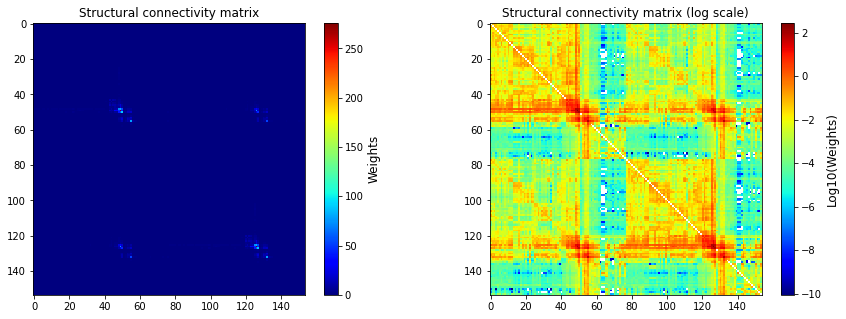

In [10]:

# Plot the resulting connectivity weights at linear and log scale
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cs_lin = axes[0].imshow(sum_conn_new, cmap='jet', aspect='equal', interpolation='none')
axes[0].set_title('Structural connectivity matrix', fontsize=12)
axcb_lin = plt.colorbar(cs_lin, ax=axes[0])
axcb_lin.set_label('Weights', fontsize=12)

cs_log = axes[1].imshow(np.log10(sum_conn_new), cmap='jet', aspect='equal', interpolation='none')
axes[1].set_title('Structural connectivity matrix (log scale)', fontsize=12)
axcb_log = plt.colorbar(cs_log, ax=axes[1])
axcb_log.set_label('Log10(Weights)', fontsize=12)


In [11]:
import h5py

# the method returns the tract lengths between the brain areas in the selected parcellation
def construct_tract_lengths(centres):
    n_regions = len(centres)
    tracts = np.zeros((n_regions, n_regions), dtype=float)
    for i_ind, inj in enumerate(centres):
        for i_targ, targ in enumerate(centres):
            tracts[i_ind, i_targ] = np.sqrt(
                (inj[0] - targ[0]) ** 2 + (inj[1] - targ[1]) ** 2 + (inj[2] - targ[2]) ** 2)
    return tracts

def write_connectivity_to_h5_file(connectivity, filename):
    #save the structural conn matrix
    f = h5py.File(os.path.join(data_path, filename), "w")
    for attr in ["weights", "tract_lengths", "centres", "region_labels"]:
        if attr == "region_labels":
            f.create_dataset(attr, data=getattr(connectivity, attr).astype(h5py.string_dtype(encoding='utf-8')))

        else:
            f.create_dataset(attr, data=getattr(connectivity, attr))
    f.close()  
    

In [12]:
# Write the resulting connectivity to .h5 TVB compatible file...
write_connectivity_to_h5_file(new_conn, "Connectivity_SummedSubcortical.h5")
# ... along with the corresponding mapping from regions to major structures.
np.save("major_structs_labels.npy", new_major_structs_labels)
np.save("voxel_count.npy", new_voxel_count)

In [13]:
from six import string_types
from collections import OrderedDict
from tvb.contrib.scripts.utils.data_structures_utils import is_integer, is_float
from examples.tvb_nest.notebooks.cerebellum.utils import print_conn
    
    
def print_weights_from(label, inds, region_labels, weights, maxrow=200):
    for iH, hemi in enumerate(["Right", "Left"]):
        arginds = np.argsort(weights[inds[iH], :])[::-1]
        d = OrderedDict()
        d[("Region", 55)] = ["%d.%s" % (iR, region_labels[iR]) for iR in arginds]
        d[("Weight", 30)] = weights[inds[iH], arginds]
        d[("Total weights to", 30)] = np.nansum(weights[arginds], axis=1)
        print_conn(d, prnt="\nConnections from %s %s to:\n" % (hemi, label), 
                   maxrow=maxrow, printit=True);
    
    
def print_weights_to(label, inds, region_labels, weights, maxrow=200):
    for iH, hemi in enumerate(["Right", "Left"]):
        arginds = np.argsort(weights[:, inds[iH]])[::-1]
        d = OrderedDict()
        d[("Region", 55)] = ["%d.%s" % (iR, region_labels[iR]) for iR in arginds]
        d[("Weight", 30)] = weights[arginds, inds[iH]]
        d[("Total weights from", 30)] = np.nansum(weights[:, arginds], axis=0)
        print_conn(d, prnt="\nConnections to %s %s from:\n" % (hemi, label), 
                   maxrow=maxrow, printit=True);
        

In [14]:
d = OrderedDict()
d[("Region", 55)] = ["%d.%s" % (iR, reg) for iR, reg in enumerate(new_conn.region_labels)]
d[("Major Structure", 30)] = new_major_structs_labels
d[("Voxels", 10)] = new_voxel_count
d[("Total weights to/from", 21)] = np.array(["%0.3f/%0.3f" % ( wt, wf) 
                                             for wt, wf in zip(np.nansum(new_conn.weights, axis=1), 
                                                               np.nansum(new_conn.weights, axis=0))])
print_conn(d, prnt="", printit=True);

Region.................................................Major Structure...............Voxels....Total weights to/from
--------------------------------------------------------------------------------------------------------------------
0.Right Frontal pole, cerebral cortex..................Right Isocortex...............514.......3.149/6.361..........
1.Right Primary motor area.............................Right Isocortex...............11760.....1.874/6.373..........
2.Right Secondary motor area...........................Right Isocortex...............10098.....2.335/6.994..........
3.Right Primary somatosensory area, nose...............Right Isocortex...............1358......1.201/5.399..........
4.Right Primary somatosensory area, barrel field.......Right Isocortex...............10306.....1.374/6.265..........
5.Right Primary somatosensory area, lower limb.........Right Isocortex...............3254......1.834/5.633..........
6.Right Primary somatosensory area, mouth..............Right Iso

In [15]:
inds = {}
inds["m1"] = []
inds["s1brl"] = []
inds["supcol"] = []
inds["facial"] = []
inds["spv"] = []
inds["ponssens"] = []
inds["ponsmotor"] = []
inds["thal"] = []
inds["ansilob"] = []
inds["dentate"] = []
inds["interposed"] = []
inds["oliv"] = []
for iR, reg in enumerate(new_conn.region_labels):
    if "Primary motor area" in reg:
        inds["m1"].append(iR)
    if "barrel" in reg:
        inds["s1brl"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Facial" in reg:
        inds["facial"] .append(iR)
    if "Medulla SPV" in reg:
        inds["spv"].append(iR)
    if "Pons Sensory" in reg:
        inds["ponssens"] .append(iR)
    if "Pons Motor" in reg:
        inds["ponsmotor"].append(iR)
    if "Thalamus" in reg:
        inds["thal"].append(iR)
    if "Ansiform lobule" in reg:
        inds["ansilob"].append(iR)
    if "Dentate nucleus" in reg:
        inds["dentate"].append(iR)
    if "Interposed nucleus" in reg:
        inds["interposed"].append(iR)
    if "Inferior olivary complex" in reg:
        inds["oliv"].append(iR)
inds["m1s1brl"] = inds["m1"]  + inds["s1brl"]
inds["sens"] = inds["spv"]  + inds["ponssens"]
inds["motor"] = inds["supcol"]  + inds["facial"]
inds["cereb"] = inds["ansilob"] + inds["dentate"] + inds["interposed"] + inds["oliv"]
inds["all"] = inds["m1s1brl"] + inds["motor"] + inds["sens"] + inds["thal"] + inds["cereb"]
for key, val in inds.items():
    inds[key] = np.array(val)
print(new_conn.region_labels[inds["all"]])

['Right Primary motor area' 'Left Primary motor area'
 'Right Primary somatosensory area, barrel field'
 'Left Primary somatosensory area, barrel field'
 'Right Superior colliculus, motor related'
 'Left Superior colliculus, motor related' 'Right Facial motor nucleus'
 'Left Facial motor nucleus' 'Right Medulla SPV' 'Left Medulla SPV'
 'Right Pons Sensory' 'Left Pons Sensory' 'Right Thalamus' 'Left Thalamus'
 'Right Ansiform lobule' 'Left Ansiform lobule' 'Right Dentate nucleus'
 'Left Dentate nucleus' 'Right Interposed nucleus'
 'Left Interposed nucleus' 'Right Inferior olivary complex'
 'Left Inferior olivary complex']


In [16]:
print("SENSORY PATHWAY:\n")
print_weights_from("Medulla SPV", inds["spv"], new_conn.region_labels, new_conn.weights, maxrow=10)
print_weights_to("Pons Sensory", inds["ponssens"], new_conn.region_labels, new_conn.weights, maxrow=10)
print_weights_from("Pons Sensory", inds["ponssens"], new_conn.region_labels, new_conn.weights, maxrow=10)
print_weights_to("Ansiform lobule", inds["ansilob"], new_conn.region_labels, new_conn.weights, maxrow=10)

print("\n\n\nMOTOR PATHWAY:\n")
print_weights_from("Primary motor area", inds["m1"], new_conn.region_labels, new_conn.weights, maxrow=10)
print_weights_to("Superior colliculus, motor related", inds["supcol"], new_conn.region_labels, new_conn.weights, maxrow=10)
print_weights_from("Superior colliculus, motor related", inds["supcol"], new_conn.region_labels, new_conn.weights, maxrow=10)
print_weights_to("Facial motor nucleus", inds["facial"], new_conn.region_labels, new_conn.weights, maxrow=10)

SENSORY PATHWAY:


Connections from Right Medulla SPV to:
Region.................................................Weight........................Total weights to..............
-------------------------------------------------------------------------------------------------------------------
55.Right Medulla.......................................3.88545.......................241.373.......................
132.Left Medulla.......................................1.11788.......................241.373.......................
56.Right Medulla SPV...................................0.529612......................7.94454.......................
53.Right Pons Motor....................................0.296719......................111.275.......................
127.Left Midbrain......................................0.278015......................429.195.......................
52.Right Pons Sensory..................................0.190471......................16.4729.......................
130.Left Pons 

In [17]:
import networkx as nx  # https://networkx.org/
from mpl_toolkits.mplot3d import Axes3D


def conn_to_graph(conn, major_structs_labels, voxel_count):
    
    G = nx.DiGraph()
    # G.add_edge('A', 'B', weight=4)
    nodes = []
    for iR, (reg, centre, msl, vc) in enumerate(zip(conn.region_labels, conn.centres, 
                                                    major_structs_labels, voxel_count)):
        nodes.append(reg)
        G.add_node(nodes[-1], ind=iR, centre=centre, major_structure_label=msl, vc=vc)
        
    for iR1, reg1 in enumerate(nodes):
        for iR2, reg2 in enumerate(nodes):
            G.add_edge(reg1, reg2, 
                       weight=conn.weights[iR2, iR1], 
                       distance=1.0/conn.weights[iR2, iR1] if conn.weights[iR2, iR1] > 0 else np.inf, 
                       tract_length=conn.tract_lengths[iR2, iR1])
        
    return G
        
    

def plot_G_conn_3D(G, nodes_kwgs={'s': 100, 'ec':"w"}, 
                   edges_kwgs={'color':"tab:gray", 'alpha': 0.01}, show=True):

    node_centres = nx.get_node_attributes(G, "centre")

    # 3d layout
    pos = nx.rescale_layout_dict(node_centres)

    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, **nodes_kwgs)

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, **edges_kwgs)


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")


    _format_axes(ax)
    fig.tight_layout()
    
    if show:
        plt.show()
    
    return fig, ax


In [18]:
G = conn_to_graph(new_conn, new_major_structs_labels, new_voxel_count)

<IPython.core.display.Javascript object>


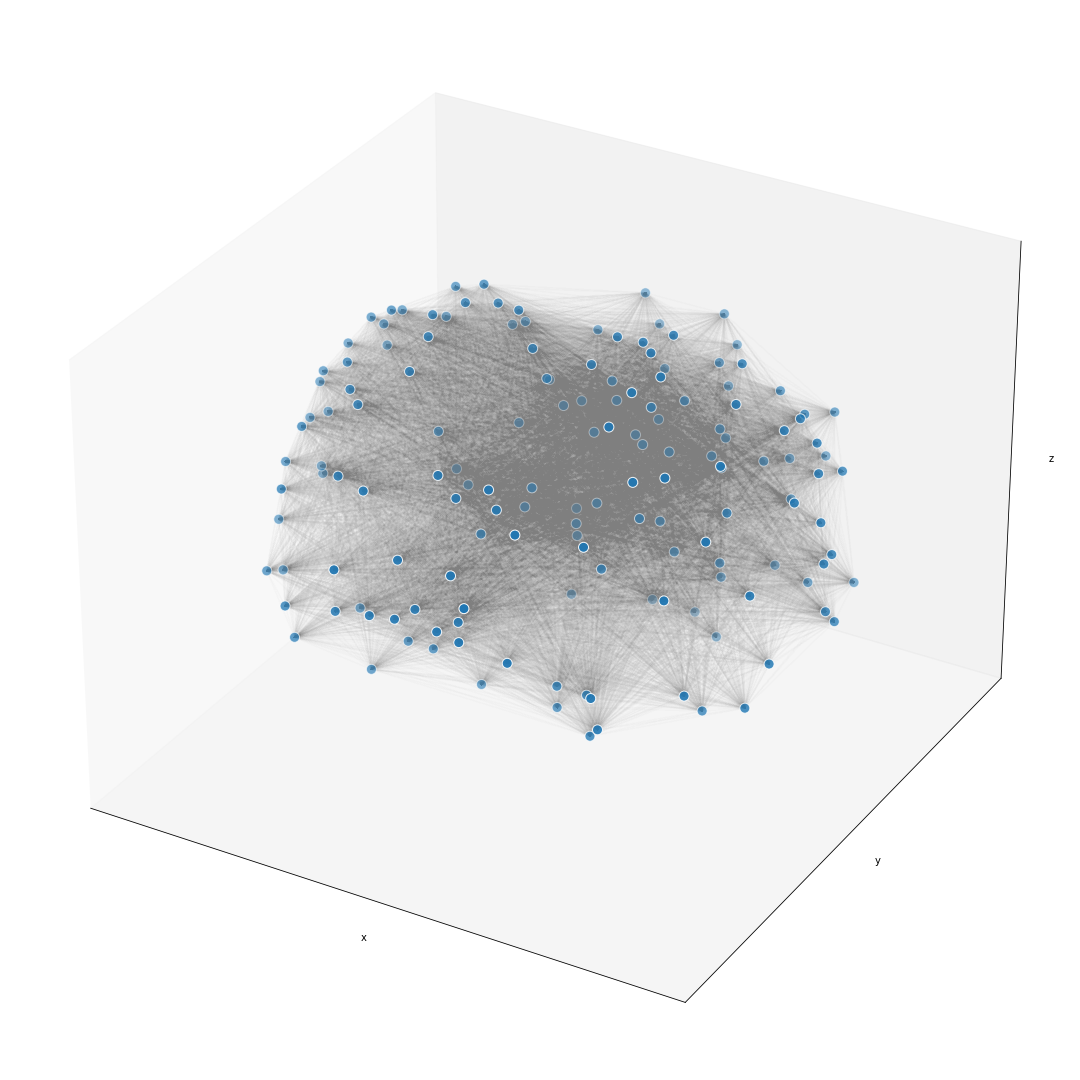

(<Figure size 1080x1080 with 1 Axes>, <Axes3DSubplot:xlabel='x', ylabel='y'>)

In [19]:
# For interactive plotting:
%matplotlib notebook 

plot_G_conn_3D(G)

In [20]:
G.nodes()

NodeView(('Right Frontal pole, cerebral cortex', 'Right Primary motor area', 'Right Secondary motor area', 'Right Primary somatosensory area, nose', 'Right Primary somatosensory area, barrel field', 'Right Primary somatosensory area, lower limb', 'Right Primary somatosensory area, mouth', 'Right Primary somatosensory area, upper limb', 'Right Primary somatosensory area, trunk', 'Right Primary somatosensory area, unassigned', 'Right Supplemental somatosensory area', 'Right Gustatory areas', 'Right Visceral area', 'Right Dorsal auditory area', 'Right Primary auditory area', 'Right Posterior auditory area', 'Right Ventral auditory area', 'Right Anterolateral visual area', 'Right Anteromedial visual area', 'Right Lateral visual area', 'Right Primary visual area', 'Right Posterolateral visual area', 'Right posteromedial visual area', 'Right Laterointermediate area', 'Right Postrhinal area', 'Right Anterior cingulate area, dorsal part', 'Right Anterior cingulate area, ventral part', 'Right P

In [21]:
source = 'Right Primary motor area' # "Right Medulla SPV"
target = 'Right Facial motor nucleus' # "Right Ansiform lobule" # "Right Pons Sensory"


sp = nx.shortest_path(G, source, target, weight='distance')  # distance = 1/weight
print("Shortest Path:\n", sp)

spl = nx.shortest_path_length(G, source, target, weight='distance') 
print("Shortest Path Length:\n", spl)

w = 1.0 / spl / (len(sp) - 1)
print("Shortest Path Weight = 1.0 / ShortestPathLength / (len(ShortestPath)-1):\n", w)

Shortest Path:
 ['Right Primary motor area', 'Right Thalamus', 'Right Midbrain', 'Right Medulla', 'Right Facial motor nucleus']
Shortest Path Length:
 1.1081700400745862
Shortest Path Weight = 1.0 / ShortestPathLength / (len(ShortestPath)-1):
 0.22559714751282534
